Text(0.5, 0, 'Train Photo')

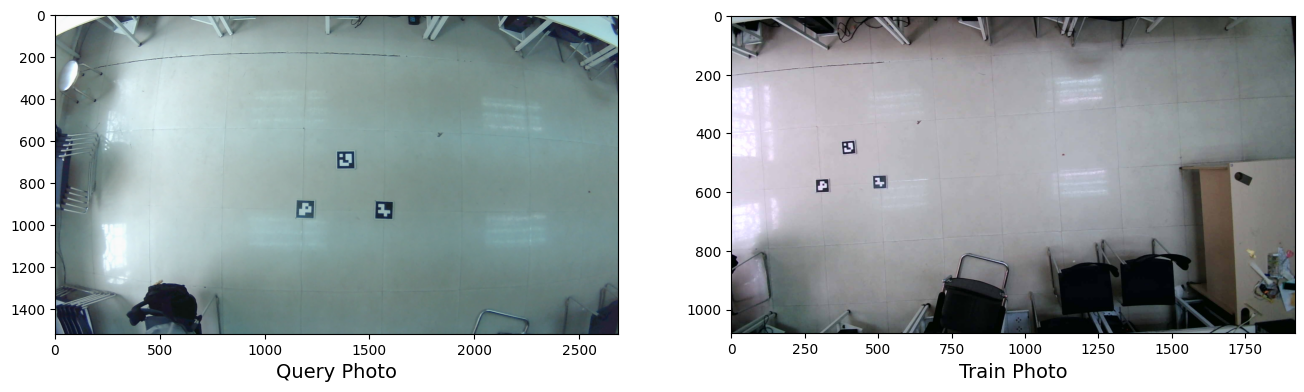

In [269]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import imageio
import warnings

cv.ocl.setUseOpenCL(0)
warnings.filterwarnings('ignore')

feature_extraction_algo = 'sift'
feature_to_match = 'bf'

train_photo = cv.imread('photos/train.jpg')
train_photo = cv.cvtColor(train_photo, cv.COLOR_BGR2RGB)
train_photo_gray = cv.cvtColor(train_photo, cv.COLOR_RGB2GRAY)

query_photo = cv.imread('photos/query.jpg')
query_photo = cv.cvtColor(query_photo, cv.COLOR_BGR2RGB)
query_photo_gray = cv.cvtColor(query_photo, cv.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout = False, figsize=(16, 9))
ax1.imshow(query_photo, cmap='gray')
ax1.set_xlabel('Query Photo', fontsize=14)

ax2.imshow(train_photo, cmap='gray')
ax2.set_xlabel('Train Photo', fontsize=14)


In [270]:
def select_descriptor_method(image, method=None):
    assert method is not None, " 'sift', 'surf', 'orb', 'brisk' "

    if method == 'sift':
        descriptor = cv.SIFT.create()
    elif method == 'surf':
        descriptor = cv.xfeatures2d.SURF.create()
    elif method == 'orb':
        descriptor = cv.ORB.create()
    elif method == 'brisk':
        descriptor = cv.BRISK.create()
    
    keypoints, features = descriptor.detectAndCompute(image, None)

    return keypoints, features

In [271]:
keypoints_train_img, feature_train_img = select_descriptor_method(train_photo_gray, method=feature_extraction_algo)

keypoints_query_img, feature_query_img = select_descriptor_method(query_photo_gray, method=feature_extraction_algo)

In [272]:
for keypoint in keypoints_query_img:
    x, y = keypoint.pt
    size = keypoint.size
    orientation = keypoint.angle
    response = keypoint.response
    octave = keypoint.octave
    class_id = keypoint.class_id

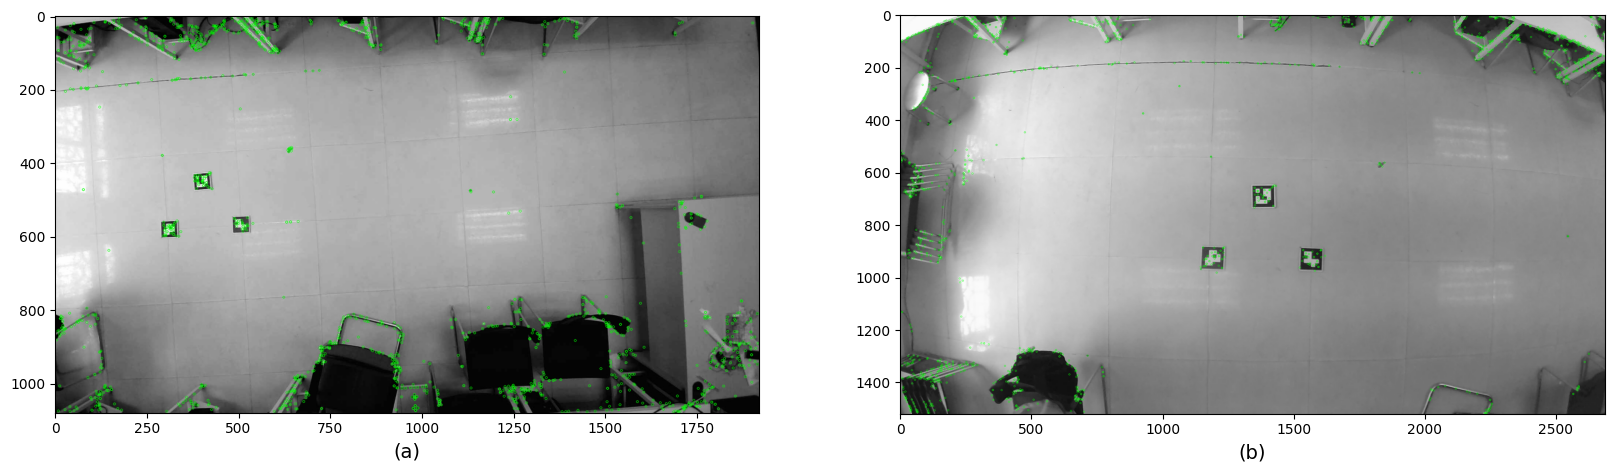

In [273]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), constrained_layout=False)

ax2.imshow(cv.drawKeypoints(query_photo_gray, keypoints_query_img, None, color=(0, 255, 0)))
ax2.set_xlabel('(b)', fontsize=14)

ax1.imshow(cv.drawKeypoints(train_photo_gray, keypoints_train_img, None, color=(0, 255, 0)))
ax1.set_xlabel('(a)', fontsize=14)

plt.savefig('./output/' + feature_extraction_algo + '_feature_img' + '.jpeg', bbox_inches = 'tight', dpi=300, format='jpeg')
plt.show()



In [274]:
def create_matching_object(method, crossCheck):
    if method == 'sift' or method == 'surf':
        bf = cv.BFMatcher(cv.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=crossCheck)
    
    return bf

In [275]:
def keypoints_matching(feature_train_img, feature_query_img, method):
    bf = create_matching_object(method, crossCheck=True)

    best_matches = bf.match(feature_train_img, feature_query_img)

    raw_matches = sorted(best_matches, key=lambda x: x.distance)
    print('Raw matches with Brute Force', len(raw_matches))

    return raw_matches

In [276]:
def keypoints_matching_KNN(feature_train_img, feature_query_img, ratio, method):
    bf = create_matching_object(method, crossCheck=False)

    raw_matches = bf.knnMatch(feature_train_img, feature_query_img, k=2)

    print('Raw matches with KNN', len(raw_matches))

    knn_matches = []

    for m, n in raw_matches:
        if m.distance < n.distance * ratio:
            knn_matches.append(m)

    return knn_matches

Drawing matched features for  bf
Raw matches with Brute Force 411


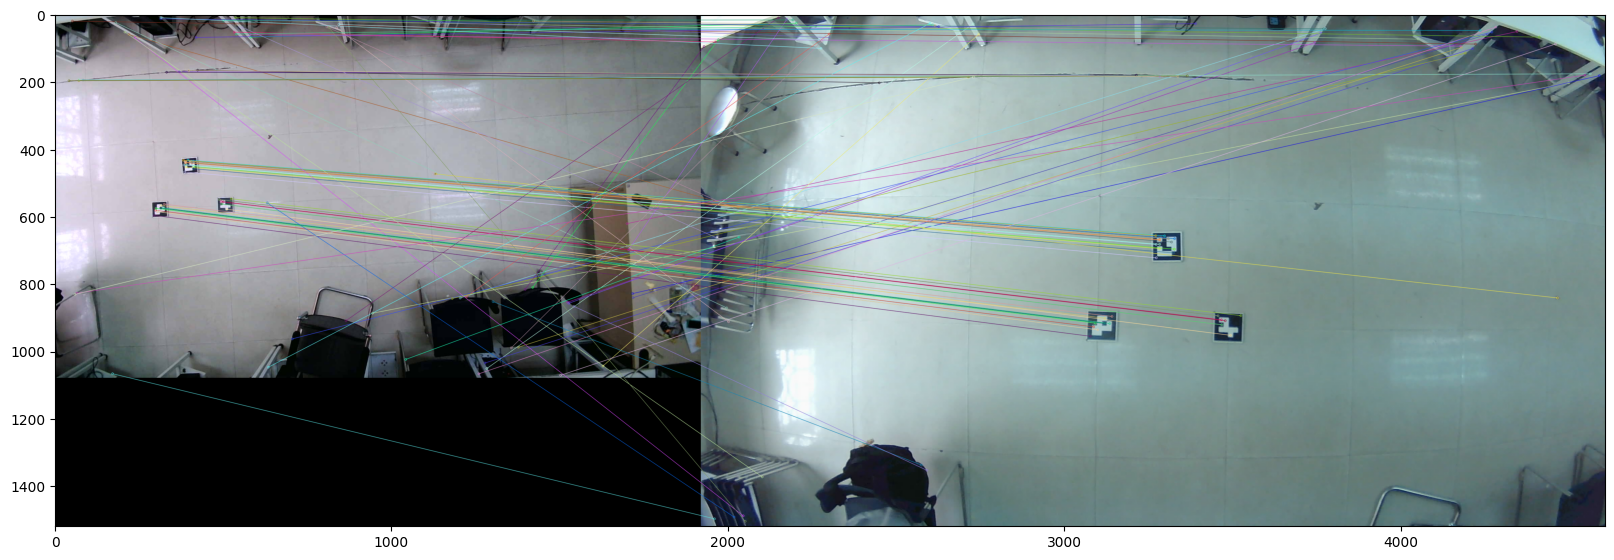

In [277]:
print('Drawing matched features for ', feature_to_match)

fig = plt.figure(figsize=(20, 8))

if feature_to_match == 'bf':
    matches = keypoints_matching(feature_train_img, feature_query_img, method=feature_extraction_algo)

    mapped_feature_image = cv.drawMatches(train_photo, keypoints_train_img, query_photo, keypoints_query_img, matches[:100], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_to_match == 'knn':
    matches = keypoints_matching_KNN(feature_train_img, feature_query_img, method=feature_extraction_algo)

    mapped_feature_image = cv.drawMatches(train_photo, keypoints_train_img, query_photo, keypoints_query_img, np.random.choice(matches, 100), None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(mapped_feature_image)

In [278]:
def homography_stitching(keypoints_train_img, keypoints_query_img, matches, reprojThresh):
    keypoints_train_img = np.float32([keypoint.pt for keypoint in keypoints_train_img])
    keypoints_query_img = np.float32([keypoint.pt for keypoint in keypoints_query_img])

    if len(matches) > 4:
        points_train = np.float32([keypoints_train_img[m.queryIdx] for m in matches])
        points_query = np.float32([keypoints_query_img[m.trainIdx] for m in matches])

        # Find homography matrix
        (H, status) = cv.findHomography(points_train, points_query, cv.RANSAC, reprojThresh)
        
        return (matches, H, status)
    else:
        return None

In [279]:
M = homography_stitching(keypoints_train_img, keypoints_query_img, matches, reprojThresh=4)

if M is None:
    print('Error')

(matches, Homography_Matrix, status) = M


print(Homography_Matrix)

[[ 1.89435646e+00 -3.91873161e-01  7.36164113e+02]
 [ 2.14988254e-01  1.64736621e+00 -1.70429033e+02]
 [ 8.09415764e-05 -1.80349333e-04  1.00000000e+00]]


In [280]:
width = query_photo.shape[1] + train_photo.shape[1]
print(width)

height = max(query_photo.shape[0], train_photo.shape[0])
print(height)

4608
1520


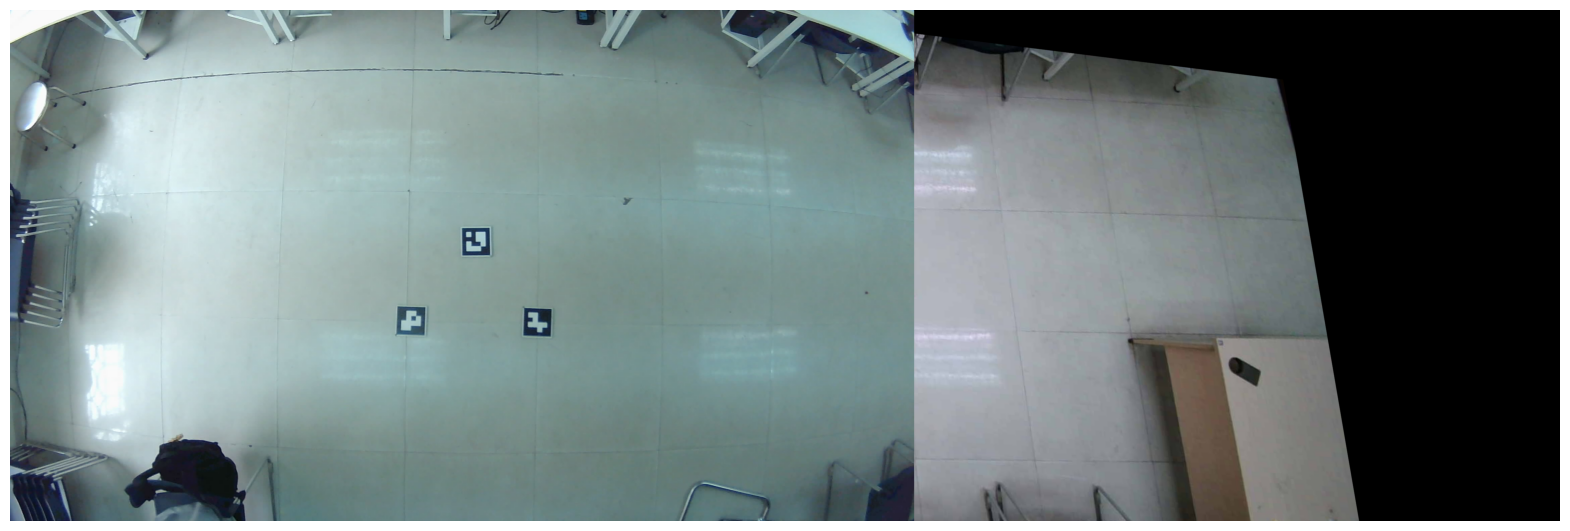

In [281]:
result = cv.warpPerspective(train_photo, Homography_Matrix, (width, height))

result[0:query_photo.shape[0], 0:query_photo.shape[1]] = query_photo

plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(result)